# Time Series Analysis with LSTMs in Keras.

I recommend using venv to set up virtual environments. These are isolated Python installations and then you won't run into conflicts there.

To setup, type "python3 -m venv <envname>". To activate type ". <envname>/bin/activate" (the "." reads the contents into the shell which sets up the proper environment variables. If you want to leave type "deactivate".

In this notebook, we will construct an LSTM with Keras. These are recurrent neural networks that are able to more actively manage their internal state to enable long-term interactions.

Again, we will show the basic steps to use these models, but continue to use the simple ARMA model data. Using this notebook, you can then try out other data sources, and try other topologies and learning scheduls.

Prior to running this, install keras, tensorflow, numpy, statsmodels (for the data), and matplotlib. To see this notebook, install jupyter. Then, go to this directory and type "jupyter notebook" and you can open the notebook.

Execute lines by shift+Return.

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.recurrent import LSTM
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


## Constructing the data

Again, the ARMA model data we have used so far.

One modification here is that we divide the data by 50 to make sure the range lies between -1 and 1 which is what most Neural Network activation functions can only cover.

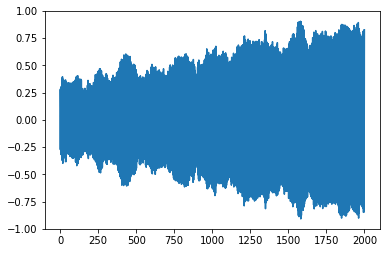

In [16]:
from statsmodels.tsa.arima_process import arma_generate_sample
xs = arma_generate_sample([1.0, -0.6, 1.0, -0.6], [1.0], 2001, 1.0, burnin=100) / 50
plt.plot(xs)

## Prepare the data

Data preparation is similar to what we need to do for the general machine learning: we want to transform the time series prediction problem into a supervised learning set with clearly defined input and output data.

The difference is that we don't do any explicit embedding because this is something the network should do by itself (if necessary).

So essentially, we take all the data as input except for the last point, and all the data except for the first point as output, so that we can predict x[i+1] from x[i].

In [17]:
x = xs[:-1]; y = xs[1:]

Just to check, how dissimilar the input and output are. One interesting thing about this highly oscillatory data is that it does not make sense to just predict the input.

In [8]:
def nmse(y1, y2):
    return np.linalg.norm(y1 - y2)**2 / np.linalg.norm(y2)**2

In [9]:
nmse(x, y)

1.9915236259792748

Finally, since Keras expects sequence data to come in a three dimensional array with dimensions (number of data points, number of time points, the data), we have to enlarge our simple arrays to become three dimensional.

In [18]:
xtrain = x.reshape(len(x), 1, 1)
ytrain = y.reshape(len(y), 1)

## Set up the model

Keras main model is the Sequential model which is a list of layers of different types stacked on one another. The LSTM is in keras.layers.recurrent. Note that the LSTM layer only contains the LSTM itself including the update, but not the final layer which takes the hidden state and computes the prediction. This is why we add another Dense(1) layer.

The LSTM object gets three parameters:
   1. the first is the dimension of the hidden state. We set it to 10.
   2. the batch_input_shape. This is a bit technical, but the LSTM needs to know beforehand what the batch size is it will be trained against (see below).
   3. stateful=True means that between batches, the state of the model is retained.

In [19]:
bs = 1
model = Sequential()
model.add(LSTM(10, batch_input_shape=(bs, 1, 1), stateful=True))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

For the actual training, we specify epochs=1 because we need to reset the state after the epoch. We also specify shuffle=False such that we are considering the different data points as they come in the time sequence.

Now a word on the batch size. The way this is implemented in Keras right now is that if stateful=True, the internal state is preserved _across batches_, but individually for the different positions in a batch.

So if you have batch size 10, the internal state of data point i in the batch will be preserved and reused for data point i in the next batch.

This can in principle be used to train quicker on batches of data but only after the data points are reshuffled, because otherwise one would skip points in each batch.

If properly done, one can speed up computations by learning on different parts of the time series in one go (and that is faster than doing it explicitly in Python), but for now let us stick with bs=1. You can try longer ranges and will see that learning does not converge anymore, because points are essentially decoupled.

In [20]:
for i in range(3):
    model.fit(xtrain, ytrain, epochs=1, batch_size=bs, shuffle=False)
    model.reset_states()

Epoch 1/1
2000/2000 [==============================] - 15s - loss: 0.0277    
Epoch 1/1
2000/2000 [==============================] - 14s - loss: 0.0021    
Epoch 1/1
2000/2000 [==============================] - 15s - loss: 0.0020    


Technically, we already did this in the last iteration, but doesn't hurt to reset the state.

In [21]:
model.reset_states()

Now let's predict on the training data. Note that here again, the batch size from the model is used. Once defined, you always have to use the same batchsize!

In [22]:
yhat = model.predict(xtrain, batch_size=bs)

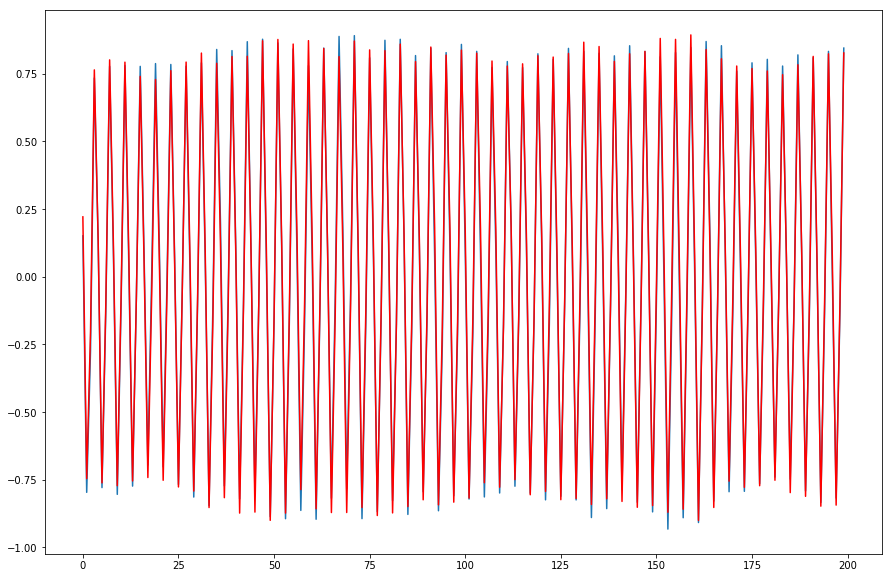

In [23]:
start=1800; stop=2000
plt.figure(figsize=(15,10))
plt.plot(yhat[start:stop], '-', ytrain[start:stop], 'r-')

In [24]:
nmse(yhat, ytrain)

0.044226767344384479